<a href="https://colab.research.google.com/github/kumagaimasahito/Eternity/blob/master/eternity_group2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
IBMQ.save_account("fe66bbc4d0cb2af50475dcc2bc1b543b873a101d8586ce7c437d913981b3ac804318a694e9ee3ac3232cd8e49542a7af5ae4ee7f64245984bd0ffc548f215a58")
IBMQ.load_account()

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/credentials/configrc.py:130: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from qiskit import *
from qiskit.tools.visualization import plot_histogram
import math

In [0]:
def cplot(current_qubits, prb, qubo_prb):
    num = 2
    cmap=['#999999','#FFFF99','#CC99FF','#FF99FF','#99FF99','#99CCFF','#FFCCCC']
    fig = plt.figure()
    ax = plt.axes()
    #ax = fig.add_subplot(111)
    pcs = []
    for item in current_qubits:
        #print(item)
        #print(qubo_prb[item][0], qubo_prb[item][1])
        #print(prb[qubo_prb[item][0]][qubo_prb[item][1]])
        pcs.append(prb[qubo_prb[item][0]][qubo_prb[item][1]])
    #print("pcs:", pcs)
    for i in range(num*num):
        x = i%num
        #y = 5-i//num
        y = 1-i//num
        tri = plt.Polygon(((x,y),(x,y+1),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)
        tri = plt.Polygon(((x,y+1),(x+1,y+1),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)
        tri = plt.Polygon(((x+1,y),(x+1,y+1),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)
        tri = plt.Polygon(((x,y),(x+1,y),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)

    tmp=[]  #同じ場所にあるピース発見用
    for i in range(len(pcs)):
        location = pcs[i][0]
        lcf = 0
        if len(np.where(np.array(tmp)==location)[0])>0: lcf = 1
        x = location%num
        y = 1-location//num
        for j in range(1, len(pcs[i])):
            if lcf==0: cc = cmap[pcs[i][j]]
            else: cc='#FF0000'
            if j==1:
                tri = plt.Polygon(((x,y),(x,y+1),(x+1/2,y+1/2)),fc=cc, fill=True)
            if j==2:
                tri = plt.Polygon(((x,y+1),(x+1,y+1),(x+1/2,y+1/2)),fc=cc, fill=True)
            if j==3:
                tri = plt.Polygon(((x+1,y),(x+1,y+1),(x+1/2,y+1/2)),fc=cc, fill=True)
            if j==4:
                tri = plt.Polygon(((x,y),(x+1,y),(x+1/2,y+1/2)),fc=cc, fill=True)
            ax.add_patch(tri)
            tmp.append(location)
        ax.text(x, y+0.8,str(qubo_prb[current_qubits[i]][0]),color='black')
    plt.axis('scaled')
    ax.set_aspect('equal')
    plt.show()
#print(print(prb))
#cplot([1,8],prb, qubo_prb)
#cplot([2,7],prb, qubo_prb)
#cplot([5,7],prb, qubo_prb)

In [0]:
p = [
    [0,0,1,4],
    [0,0,4,3],
    [0,0,4,1],
    [0,0,3,4]]

In [6]:
#回転したピースを作る
#最初の１個は固定にするので回転なし
pr = []
for i, item in enumerate(p):
    tmp = []
    for j in range(4):
        tmp2=[]
        tmp2.extend(item[j:])
        tmp2.extend(item[:j])
        f=1
        for item2 in tmp:
            #すでに同じものが含まれていたら追加しない
            if np.array_equal(tmp2, item2):
                f=0
                break
        if f==1:tmp.append(tmp2)
    pr.append(tmp)
for i in range(len(pr)):
    print("pr,i:",i, pr[i])

pr,i: 0 [[0, 0, 1, 4], [0, 1, 4, 0], [1, 4, 0, 0], [4, 0, 0, 1]]
pr,i: 1 [[0, 0, 4, 3], [0, 4, 3, 0], [4, 3, 0, 0], [3, 0, 0, 4]]
pr,i: 2 [[0, 0, 4, 1], [0, 4, 1, 0], [4, 1, 0, 0], [1, 0, 0, 4]]
pr,i: 3 [[0, 0, 3, 4], [0, 3, 4, 0], [3, 4, 0, 0], [4, 0, 0, 3]]


In [7]:
print(p)

[[0, 0, 1, 4], [0, 0, 4, 3], [0, 0, 4, 1], [0, 0, 3, 4]]


In [0]:
#ボードの位置
# 00 01
# 02 03

In [0]:
def add_prb(prb, prb_qubo, qubo_prb, pi, location, pri):
    tmp = [location]
    tmp.extend(pri)
    prb[pi].append(tmp)
    prb_qubo[pi].append(len(qubo_prb))
    qubo_prb.append([pi, len(prb_qubo[pi])-1])

In [10]:
#１つのピースにつき、ピースの回転×場所分のQubitを用意する。
#配列にその情報を格納しておく。
#どのピースを, どの場所に、どの回転で
#0が２つある最初のピースは左上に固定
prb=[0]*len(p)
prb_qubo=[0]*len(p)
qubo_prb=[]

#0が２つある最初のピースを左上に固定
prb[0]=[]
prb_qubo[0]=[]
#prb[0].append([0,0,0,1,2])
#prb_qubo[0].append([0])
#qubo_prb.append([0,0])
add_prb(prb, prb_qubo, qubo_prb, 0, 0, p[0])
#qubo_counter = 1
for i in range(1, len(p)):
    prb[i]=[]
    prb_qubo[i]=[]
    #counter = 0
    num0=len(np.where(np.array(p[i])==0)[0])
    for j in range(len(pr[i])):
        location = -1
        #0が２つある他のピースは、残りの角３つのどこかに配置
        if num0==2:
            #３隅をループ。zipの２番目の引数は、どこが0になるか
            #for k, gp in zip([3,12,15],[[1,2],[0,3],[2,3]]):
            for k, gp in zip([1,2,3],[[1,2],[0,3],[2,3]]):
                #ボードの隅がグレーになっているものを選ぶ
                if pr[i][j][gp[0]]==0 and pr[i][j][gp[1]]==0:
                    add_prb(prb, prb_qubo, qubo_prb, i, k, pr[i][j])
        #0が1つあるものは、辺のどこかに配置
        elif num0==1:
            #辺上のセルをループ。zipの２番目の引数は、どこが0になるか
            for k, gp in zip([1,2,4,7,8,11,13,14],[1,1,0,2,0,2,3,3]):
                #辺の部分がグレーになっているものを選ぶ
                if pr[i][j][gp]==0:
                    add_prb(prb, prb_qubo, qubo_prb, i, k, pr[i][j])
        #それ以外のは、真ん中の4つにすべての回転で配置
        else:  
            for k in [5,6,9,10]:
                add_prb(prb, prb_qubo, qubo_prb, i, k, pr[i][j])

# Asa's
print(prb)
print(prb_qubo)
print(qubo_prb)

[[[0, 0, 0, 1, 4]], [[2, 0, 4, 3, 0], [3, 4, 3, 0, 0], [1, 3, 0, 0, 4]], [[2, 0, 4, 1, 0], [3, 4, 1, 0, 0], [1, 1, 0, 0, 4]], [[2, 0, 3, 4, 0], [3, 3, 4, 0, 0], [1, 4, 0, 0, 3]]]
[[0], [1, 2, 3], [4, 5, 6], [7, 8, 9]]
[[0, 0], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2], [3, 0], [3, 1], [3, 2]]


In [11]:
prb = [
       [[0,0,0,1,4]],
       [[1,1,0,0,4],
        [1,3,0,0,4],
        [1,4,0,0,3]],
       [[2,0,4,1,0],
        [2,0,4,3,0],
        [2,0,3,4,0]],
       [[3,4,1,0,0],
        [3,4,3,0,0],
        [3,3,4,0,0]]]

print(prb)

[[[0, 0, 0, 1, 4]], [[1, 1, 0, 0, 4], [1, 3, 0, 0, 4], [1, 4, 0, 0, 3]], [[2, 0, 4, 1, 0], [2, 0, 4, 3, 0], [2, 0, 3, 4, 0]], [[3, 4, 1, 0, 0], [3, 4, 3, 0, 0], [3, 3, 4, 0, 0]]]


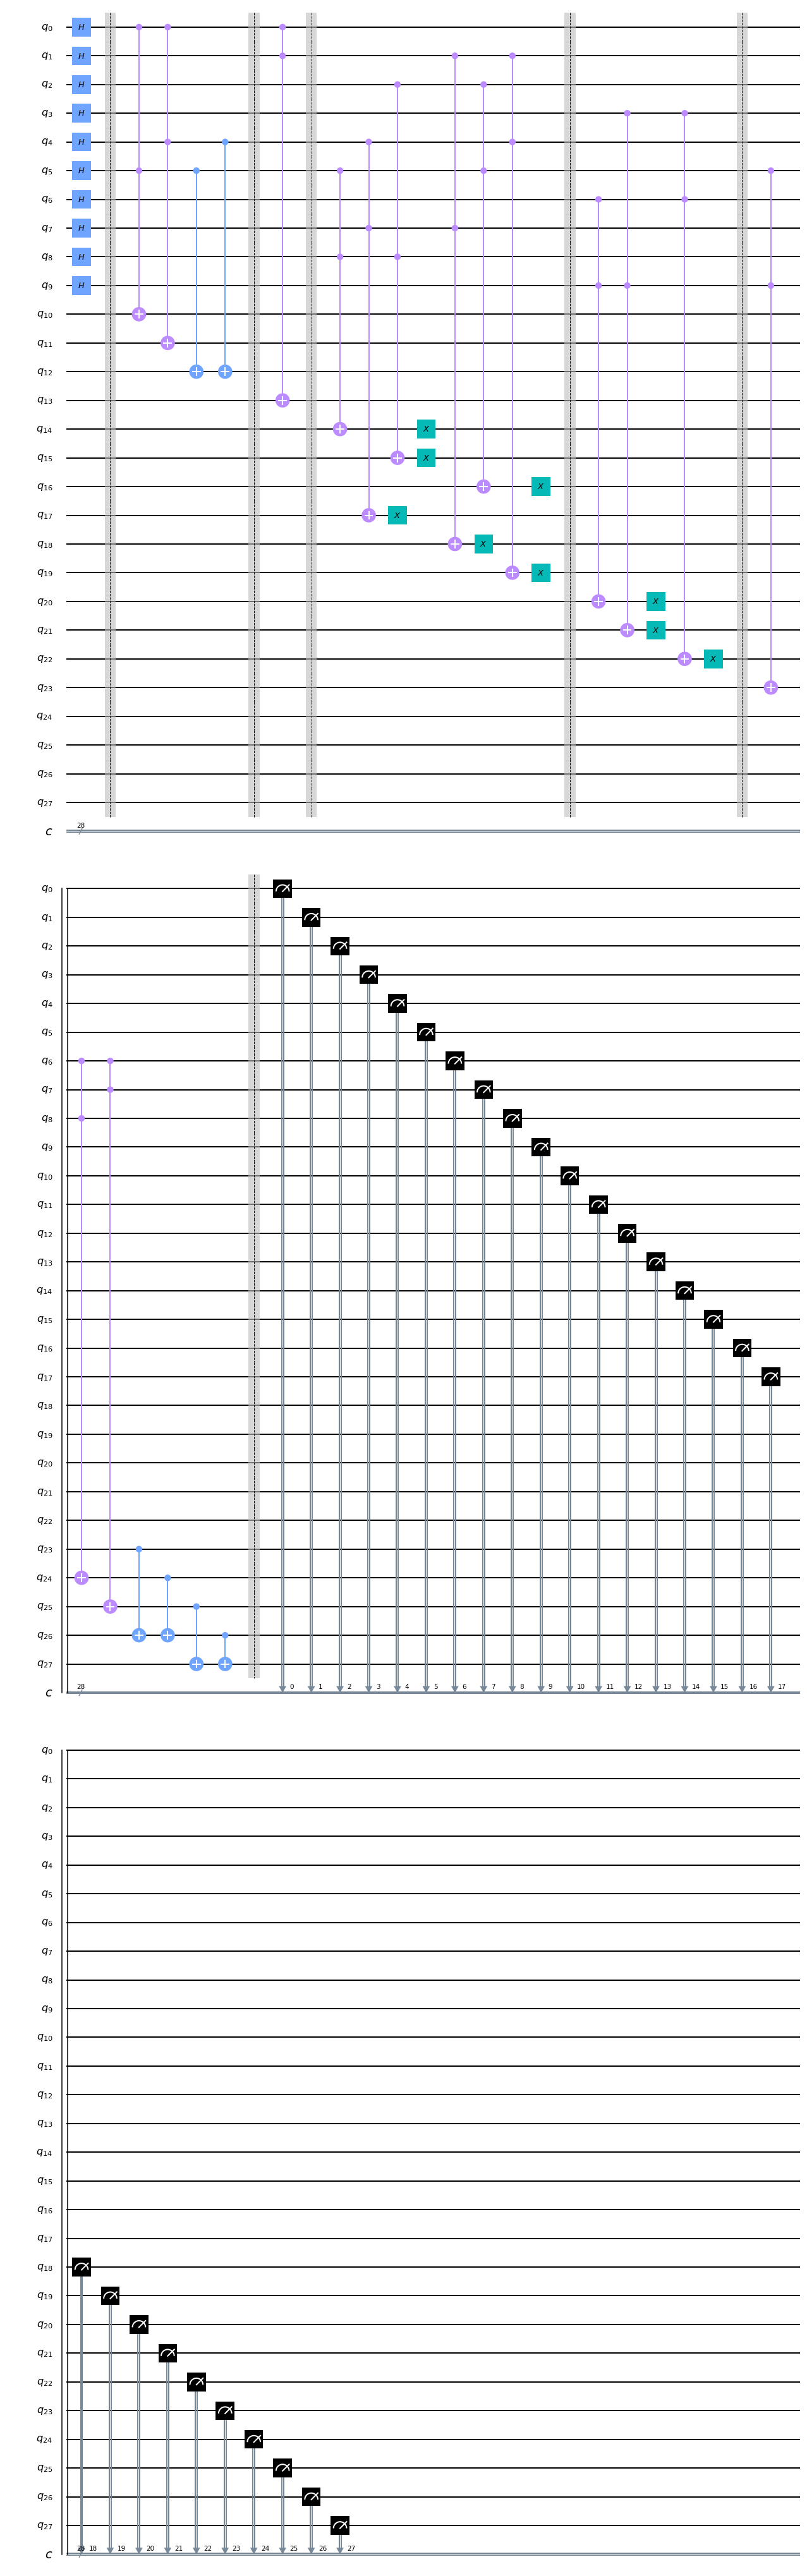

In [12]:
qbitsnum=10
#ansiranum=13
ansiranum=18
circuit = QuantumCircuit(qbitsnum+ansiranum,qbitsnum+ansiranum)
circuit.h(range(qbitsnum))
circuit.barrier()
#左上と左下のつながり
circuit.ccx(0,5,10)
circuit.ccx(0,4,11)
circuit.cx(5,12)
circuit.cx(4,12)
circuit.barrier()
#左上と右上のつながり
circuit.ccx(0,1,13)
circuit.barrier()
#ピース1の置き方を１つだけにする
circuit.ccx(5,8,14)
circuit.ccx(8,2,15)
circuit.ccx(5,2,16)
circuit.x([14,15,16])
#ピース2の置き方を１つだけにする
circuit.ccx(4,7,17)
circuit.ccx(7,1,18)
circuit.ccx(4,1,19)
circuit.x([17,18,19])
circuit.barrier()
#ピース3の置き方を１つだけにする
circuit.ccx(6,9,20)
circuit.ccx(9,3,21)
circuit.ccx(6,3,22)
circuit.x([20,21,22])
circuit.barrier()
#左下と右下のつながり
circuit.ccx(5,9,23)
circuit.ccx(8,6,24)
circuit.ccx(7,6,25)
circuit.cx(23,26)
circuit.cx(24,26)
circuit.cx(25,27)
circuit.cx(26,27)
circuit.barrier()
circuit.measure(range(qbitsnum+ansiranum),range(qbitsnum+ansiranum))
circuit.draw(output='mpl')


In [13]:
simulator = Aer.get_backend('qasm_simulator')
result=execute(circuit, backend=simulator, shots=2000).result()
counts=result.get_counts()
#print(counts)
#for j, item in enumerate(counts):
a = [i for i in counts.keys()]
res_ok=[]
for item in enumerate(a):
    #res = [int(i) for i in a[0][::-1]]
    #print("item:", item)
    res = [int(i) for i in item[1][::-1]]
    #print(res[len(res)-ansiranum:len(res)])
    #print([[1]*ansiranum])
    #if res[len(res)-ansiranum:len(res)]==[[1]*ansiranum][0]:
    target=[12,13,14,15,16,17,18,19,20,21,22,27]
    if np.array(res)[target].tolist()==[[1]*len(target)][0]:
        print(res)
        res_ok.append(res[:qbitsnum])

[1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]


[0 1 5 9]


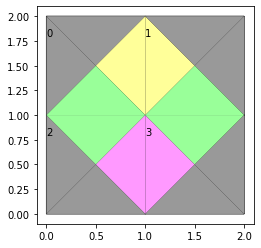

In [14]:
for item in res_ok:
    #answer = np.where(np.array(res_ok[0])==1)[0]
    answer = np.where(np.array(item)==1)[0]
    print(answer)
    cplot(answer, prb, qubo_prb)